# Assignment 1: Local Outlier Detection
## Implement the original Local Outlier Detection (LOF) method.

*Definition of `Outlier`:*  A data point that differs from the rest of the datasets and doesn't follow the expected pattern 

*It is important because* it acts as a `warning signal`, for example *detecting credit card fraud* by identifying suspicious transactions. It even helps in *quality control* by, for example detecting machine errors.

*Methods that can be used*
The samplest is `Z-score` used when it shows e.g. lengths or weights of people normally distributed.

More efficient Multivariate data method is `LOF` which we will delve into during this assignment. LOF doesn't compare data point with the entire dataset but with its nearest neighbors.



In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from pathlib import Path



In [43]:
X = pd.read_csv("class_example_dataset.csv", header=None)
print('Dataset shape:', X.shape)
print(X.head())

Dataset shape: (7, 2)
   0  1
0  7  7
1  1  6
2  1  5
3  4  1
4  3  1


[-2.31116595 -2.90133792 -2.71921367 -1.         -1.         -1.
 -1.        ]


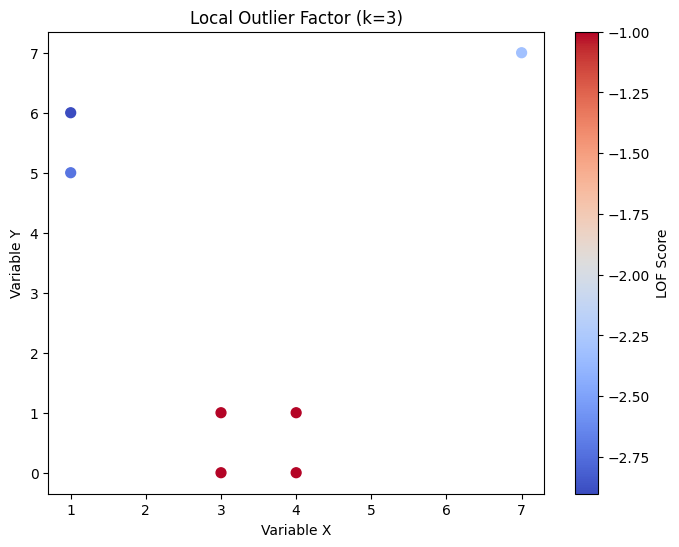

In [44]:
k = 3
lof = LocalOutlierFactor(n_neighbors=k)  
y_pred = lof.fit_predict(X)                 
scores = lof.negative_outlier_factor_       
print(scores)

X=X.to_numpy()  
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=scores, cmap='coolwarm', s=50)
plt.colorbar(label='LOF Score')
plt.title(f'Local Outlier Factor (k={k})')
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.show()

As we can see in the figure we have three outliers the more blue the stronger the outlier. Because it is far from 1 `LOF < 1`

In [45]:
for i, s in enumerate(scores):
    print(f"LOF[{i}] = {s}")

LOF[0] = -2.3111659486206197
LOF[1] = -2.9013379232505367
LOF[2] = -2.7192136675699268
LOF[3] = -1.0
LOF[4] = -1.0
LOF[5] = -1.0
LOF[6] = -1.0


When K= 3 we can see that we have 3 outlier since `LOF > 1. --- Possible outlier`.
With K=4 no strong outlier but also there are 3 outlier. 

In [46]:
for file in ["/Users/lk8545/Desktop/4DT910/A1/class_example_dataset.csv", "/Users/lk8545/Desktop/4DT910/A1/artificial_dataset.csv"]:
    if Path(file).exists():
        Y = pd.read_csv(file, header=None).to_numpy()
        n = len(Y)  
        print(f"\nRunning File {file}")
        print(f"Dataset shape: {Y.shape}")


Running File /Users/lk8545/Desktop/4DT910/A1/class_example_dataset.csv
Dataset shape: (7, 2)

Running File /Users/lk8545/Desktop/4DT910/A1/artificial_dataset.csv
Dataset shape: (20, 5)


- Build the distance table 
**D[i,j] = sqrt( (x_i - x_j)^2 + (y_i - y_j)^2 )**

In [47]:
def distancematrix (Y):
    Y = np.array(Y)
    n = len(Y)
    Distace = np.zeros((n,n), dtype=float)
    for i in range(n):  
        for j in range(n):
            vector = Y[i] - Y[j]
            Distace[i,j] = np.sqrt((vector * vector).sum())
    return Distace
Y1= pd.read_csv("class_example_dataset.csv", header=None).to_numpy( dtype=float)
D=distancematrix(Y1)  
# rounding for two decimal to check that 
# is the same values as it showen in the lecture slides  
D_rounded = np.round(D, 2) 
print(D_rounded)

[[0.   6.08 6.32 6.71 7.21 7.62 8.06]
 [6.08 0.   1.   5.83 5.39 6.71 6.32]
 [6.32 1.   0.   5.   4.47 5.83 5.39]
 [6.71 5.83 5.   0.   1.   1.   1.41]
 [7.21 5.39 4.47 1.   0.   1.41 1.  ]
 [7.62 6.71 5.83 1.   1.41 0.   1.  ]
 [8.06 6.32 5.39 1.41 1.   1.   0.  ]]


- Find the *local niegborhood* `k nearest data points excluding itself`

In [48]:
def localneighborhood(D, k):
    rows=len(D)
    k = int(k)
    if not (1 <= k <= n-1):
        raise ValueError(f"k must be in [1, {n-1}]")
    
    neighbors = np.zeros((rows, k), dtype=int)
    for i in range(rows):
        distances = D[i]
        # sort indices in order
        sort_ind = np.argsort(distances)
        # skip index 0 which is the point itself
        neighbors[i] = sort_ind[1:k+1]   
    return neighbors
Y1= pd.read_csv("class_example_dataset.csv", header=None).to_numpy()
D=distancematrix(Y1)
nieg = localneighborhood(D, k)
print(nieg)

[[1 2 3]
 [2 4 3]
 [1 4 3]
 [4 5 6]
 [3 6 5]
 [3 6 4]
 [4 5 3]]


- Compute k-distance
For each point, k-distance which is the farthest away of k nearest neighbors. 

In [49]:
def kdistance(D, nieg):
    rows=len(D)
    r = np.zeros((rows))
    for i in range(rows):
        # distances from i to its k neighbors
        dists = D[i, nieg[i]]
        # kdistance is the max distance to k neighbors
        r[i] = np.max(dists)
    return r
r = kdistance(D, nieg)
print(r)

[6.70820393 5.83095189 5.         1.41421356 1.41421356 1.41421356
 1.41421356]


[0.00, 6.08, 6.32, 6.71, 7.21, .....] we take the third neighbor and skip index 0 --> [6.08, 6.32, 6.71] the farthest k nearest neighbors is 6.70820393 ≈ 6.71 as it in the output 

In [50]:
def 𝐴𝑅𝐷𝐴(D, nieg, radius):
    n = len(D)
    RD = []
    for i in range(n):
        row = []
        for j in nieg[i]:
            row.append(max(D[i,j], radius[j]))
        RD.append(row)
    ARD = 1/k *np.array([sum(row) for row in RD])
    return ARD

ARD = 𝐴𝑅𝐷𝐴(D, nieg, r)
print(np.round(ARD, 4))

[6.3718 5.4054 5.101  1.4142 1.4142 1.4142 1.4142]


In [51]:
def LARD(ARD, eps=1e-12):
    return [1.0 / (a + eps) for a in ARD]
LRD = LARD(ARD)
print(np.round(LRD, 4))

[0.1569 0.185  0.196  0.7071 0.7071 0.7071 0.7071]


In [52]:
def lof_scores(nieg, LRD):
    D    = distancematrix(Y)
    nieg = localneighborhood(D, k)
    r    = kdistance(D, nieg)
    ARD  = ARDA(D, nieg, r)
    LRD  = LARD(ARD)
    LOF  = []
    for i in range(len(D)):
        lrd_ratios = [LRD[j] / LRD[i] for j in nieg[i]]
        LOF.append(sum(lrd_ratios) / k)
    return LOF

In [53]:
Y = pd.read_csv("/Users/lk8545/Desktop/4DT910/A1/class_example_dataset.csv", header=None).to_numpy()
for k in (3, 4):
    lof_vals = lof_scores(nieg, LRD)

    print(f"\nValue for k: {k}")
    for i, s in enumerate(lof_vals):
        print(f"LOF[{i}] = {s}")



Value for k: 3
LOF[0] = 2.3111659487051237
LOF[1] = 2.9013379233826306
LOF[2] = 2.7192136676912475
LOF[3] = 1.0
LOF[4] = 1.0
LOF[5] = 1.0
LOF[6] = 1.0

Value for k: 4
LOF[0] = 1.2077141496973578
LOF[1] = 1.0684998099980805
LOF[2] = 0.9636526192690538
LOF[3] = 1.004791699129374
LOF[4] = 1.0362227388771128
LOF[5] = 0.9818575165929123
LOF[6] = 0.981857516592912


- `k=3`, there are three clear outliers (1, 2, 0) the strongest LOF 2.9 index 1
- `k=4`, no strong outliers  All scores are close to 1, highest is idx 0 ≈ 1.21. compard to the result when k=3 the outlier signal is gone


In [54]:
Y = pd.read_csv("artificial_dataset.csv", header=None).to_numpy()
for k in (4, 5):
    lof_vals = lof_scores(nieg, LRD)

    print(f"\nValue for k: {k}")
    for i, s in enumerate(lof_vals):
        print(f"LOF[{i}] = {s}")


Value for k: 4
LOF[0] = 1.056893349870223
LOF[1] = 1.4689258225384147
LOF[2] = 1.0823130765792532
LOF[3] = 1.4599117849314729
LOF[4] = 1.0183831411877167
LOF[5] = 0.9447786145171858
LOF[6] = 1.6134885302757307
LOF[7] = 1.045947204263395
LOF[8] = 1.1358273701948343
LOF[9] = 0.9689959922001692
LOF[10] = 1.1323573613572617
LOF[11] = 0.9794678383811701
LOF[12] = 1.548369715087074
LOF[13] = 1.2789303519044235
LOF[14] = 1.0460556744658476
LOF[15] = 1.0060835850747947
LOF[16] = 1.0272664497630632
LOF[17] = 1.0615084770982959
LOF[18] = 0.972396495187995
LOF[19] = 0.9866756744894869

Value for k: 5
LOF[0] = 1.075148043221893
LOF[1] = 1.423665035309075
LOF[2] = 1.1320010424994826
LOF[3] = 1.4030486296215463
LOF[4] = 1.0330487568928097
LOF[5] = 0.9721288397984486
LOF[6] = 1.6015074112043872
LOF[7] = 1.0314890314003686
LOF[8] = 1.1004659249562527
LOF[9] = 0.9580488947646939
LOF[10] = 1.1304960691216077
LOF[11] = 0.965399060758946
LOF[12] = 1.476457738784843
LOF[13] = 1.2747110443332537
LOF[14] = 

- `k=4`, there are four outliers: idx 6 LOF ≈ 1.61 and idx 12 LOF ≈ 1.55, idx 1 ≈ 1.47 and idx 3 ≈ 1.46. The rest are ≈ 1,  the strongest is in index 6.

- `k=5`, outlier:  idx 6 LOF ≈ 1.60, idx 12 ≈ 1.48, idx 1 ≈ 1.42, idx 3 ≈ 1.40.
Compared to k=4, the signal for idx 12 weakens slightly, while idx 6 remains the strongest.